In [169]:
## Machine Learning Online Class
#  Exercise 8 | Anomaly Detection and Collaborative Filtering
#
#  Instructions
#  ------------
#
#  This file contains code that helps you get started on the
#  exercise. You will need to complete the following functions:
#
#     estimateGaussian.m
#     selectThreshold.m
#     cofiCostFunc.m
#
#  For this exercise, you will not need to change any code in this file,
#  or any other files other than those mentioned above.
#
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
from scipy import optimize

Loading movie ratings dataset.


Average rating for movie 1 (Toy Story): 4.520679 / 5




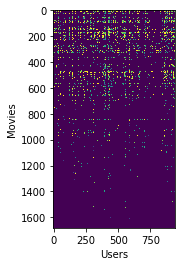

In [120]:
## =============== Part 1: Loading movie ratings dataset ================
#  You will start by loading the movie ratings dataset to understand the
#  structure of the data.
#  
print('Loading movie ratings dataset.\n\n');

#  Load data 
movies = scio.loadmat ('ex8_movies.mat');
Y = movies['Y']
R = movies['R']

#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies on 
#  943 users
#
#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a
#  rating to movie i

#  From the matrix, we can compute statistics like average rating.
print('Average rating for movie 1 (Toy Story): %f / 5\n\n' \
      %np.mean(Y[0, R[0, :]]))

#  We can "visualize" the ratings matrix by plotting it with imagesc
plt.imshow(Y)
plt.ylabel('Movies');
plt.xlabel('Users');
plt.show()

# 2 协同过滤的损失函数

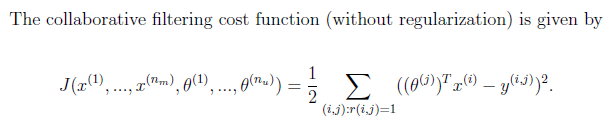

In [116]:
def cofiCostFunc(params, Y, R, num_users, num_movies, \
                                  num_features, plambda):
    #COFICOSTFUNC Collaborative filtering cost function
    #   J = COFICOSTFUNC(params, Y, R, num_users, num_movies, ...
    #   num_features, lambda) returns the cost for the
    #   collaborative filtering problem.
    #

    # Unfold the U and W matrices from params
    
    X = np.reshape(params[:num_movies*num_features], (num_movies, num_features)) 
    Theta = np.reshape(params[num_movies*num_features:], \
                    (num_users, num_features))


    # You need to return the following values correctly
    J = 0


    # ====================== YOUR CODE HERE ======================
    # Instructions: Compute the cost function for collaborative
    #               filtering. Concretely, you should first implement the cost
    #               function (without regularization) and make sure it is
    #               matches our costs. Finally, you should implement
    #               regularization.
    #
    # Notes: X - num_movies  x num_features matrix of movie features
    #        Theta - num_users  x num_features matrix of user features
    #        Y - num_movies x num_users matrix of user ratings of movies
    #        R - num_movies x num_users matrix, where R(i, j) = 1 if the 
    #            i-th movie was rated by the j-th user
    #
   
    '''temp_1 = ((X @ Theta.T) * R - Y)**2
    temp_2 = (((X @ Theta.T) - Y)**2) * R
    print(temp_1)
    print(temp_2)'''
    J = 0.5 * np.sum((((X @ Theta.T) - Y)**2) * R) + 0.5 * plambda * np.sum(Theta**2) + 0.5 * plambda * np.sum(X**2)
    

    # =============================================================

    return J


In [109]:
R_test

array([[ True, False,  True],
       [ True,  True,  True],
       [False, False,  True],
       [ True,  True, False]], dtype=bool)

In [ ]:
'''用test case中数据
temp_1 = ((X @ Theta.T) * R - Y)**2
[[ 246.8041    4.        6.7081]
 [  18.7489  103.8361   81.9025]
 [  81.       49.       20.3401]
 [   6.6049  150.5529  225.    ]]
temp_2 = (((X @ Theta.T) - Y)**2) * R
[[ 246.8041    0.        6.7081]
 [  18.7489  103.8361   81.9025]
 [   0.        0.       20.3401]
 [   6.6049  150.5529    0.    ]]
You must include the Y matrix when you multiply by R, 
because the submit grader's test case has some Y values 
that are non-zero even though the R matrix says it has not been rated. 
It's a defect in the submit grader's test case.
因temp1中减去Y的操作，已经置零的位置又附了值'''

In [121]:
## ============ Part 2: Collaborative Filtering Cost Function ===========
#  You will now implement the cost function for collaborative filtering.
#  To help you debug your cost function, we have included set of weights
#  that we trained on that. Specifically, you should complete the code in 
#  cofiCostFunc.m to return J.

#  Load pre-trained weights (X, Theta, num_users, num_movies, num_features)
params = scio.loadmat ('ex8_movieParams.mat');
X = params['X']
Theta = params['Theta']
num_users = params['num_users']
num_movies = params['num_movies']
num_features = params['num_features']

#  Reduce the data set size so that this runs faster
num_users = 4; num_movies = 5; num_features = 3;
X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]

#  Evaluate cost function
J = cofiCostFunc(np.append(X.ravel(),Theta.ravel(),axis=None), Y, R, num_users, num_movies, \
               num_features, 0); # In order to use an on-the-shelf minimizer such as fmincg, the cost function has
                                 # been set up to unroll the parameters into a single vector params.
           
print('Cost at loaded parameters: %f '\
         '\n(this value should be about 22.22)\n'%J);


Cost at loaded parameters: 22.224604 
(this value should be about 22.22)



In [24]:
np.any(params['X']==0)

False

In [25]:
np.any(params['Theta']==0)

False

数据集中X, Theta均没有0值
X为电影特征矩阵
Theta为用户偏好矩阵

# 3. 协同过滤的梯度

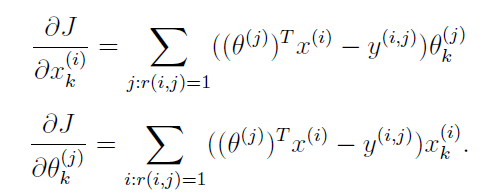

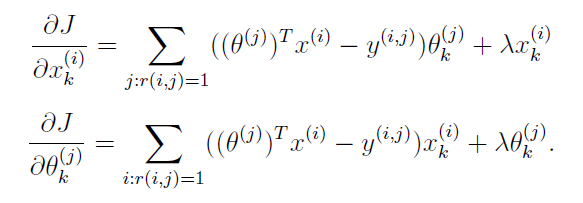

In [139]:
def cofiGradient(params, Y, R, num_users, num_movies, \
                                  num_features, plambda):
    #COFIDRADIENT Collaborative filtering gradientfunction
    #   grad = COFIDRADIENT(params, Y, R, num_users, num_movies, ...
    #   num_features, lambda) returns the cost and gradient for the
    #   collaborative filtering problem.
    #

    # Unfold the U and W matrices from params
    
    X = np.reshape(params[:num_movies*num_features], (num_movies, num_features)) 
    Theta = np.reshape(params[num_movies*num_features:], \
                    (num_users, num_features))


    # You need to return the following values correctly
  
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)

    # ====================== YOUR CODE HERE ======================
    # Instructions: Compute the gradient for collaborative
    #               filtering. Concretely, you should implement the 
    #               gradient and use the checkCostFunction routine to check
    #               that the gradient is correct. Finally, you should implement
    #               regularization.
    #
    # Notes: X - num_movies  x num_features matrix of movie features
    #        Theta - num_users  x num_features matrix of user features
    #        Y - num_movies x num_users matrix of user ratings of movies
    #        R - num_movies x num_users matrix, where R(i, j) = 1 if the 
    #            i-th movie was rated by the j-th user
    #
    # You should set the following variables correctly:
    #
    #        X_grad - num_movies x num_features matrix, containing the 
    #                 partial derivatives w.r.t. to each element of X
    #        Theta_grad - num_users x num_features matrix, containing the 
    #                     partial derivatives w.r.t. to each element of Theta
    #
    
    
    X_grad = ((X @ Theta.T - Y) * R) @ Theta + plambda * X
    Theta_grad = ((X @ Theta.T - Y) * R).T @ X + plambda * Theta
    
    
    # =============================================================

    grad = np.append(X_grad.ravel(),Theta_grad.ravel(),axis=None)
    
    return grad


test case

In [137]:
params_test = np.array([1,5,2,6,3,7,4,8,9,12,10,13,11,14]) / 10
#Y = magic(4);
Y_test = np.array([16,2,3,13,5,11,10,8,9,7,6,12,4,14,15,1]).reshape(4,4)
Y_test = Y_test[:,:3];
R_test = np.array([[1, 0, 1], [1, 1, 1], [0, 0, 1], [1, 1, 0]]) > 0.5;     # R is logical
Y_test = Y_test * R_test
nusers_test = 3;
nmovies_test = 4;
nfeatures_test = 2;
plambda = 0;
J = cofiCostFunc(params_test, Y_test, R_test, nusers_test, nmovies_test, nfeatures_test, plambda)
grad = cofiGradient(params_test, Y_test, R_test, nusers_test, nmovies_test, nfeatures_test, plambda)
print(J)
print(grad)

311.62915
[-16.188 -21.438 -23.544 -30.462  -5.159  -6.566 -14.972 -19.544  -3.423
 -12.259  -7.028 -16.06   -3.414  -9.742]


测试通过，注意python和MATLAB不同的reshape顺序

In [133]:
np.array([16,2,3,13,5,11,10,8,9,7,6,12,4,14,15,1]).reshape(4,4)[:,:3]*(np.array([[1, 0, 1], [1, 1, 1], [0, 0, 1], [1, 1, 0]]) > 0.5)

array([[16,  0,  3],
       [ 5, 11, 10],
       [ 0,  0,  6],
       [ 4, 14,  0]])

In [132]:
np.array([[1, 0, 1], [1, 1, 1], [0, 0, 1], [1, 1, 0]]) > 0.5

array([[ True, False,  True],
       [ True,  True,  True],
       [False, False,  True],
       [ True,  True, False]], dtype=bool)

In [77]:
#def computeNumericalGradient(J, theta): # 怎样实现原MATLAB代码中函数句柄？
def computeNumericalGradient(J, theta, 
                                   Y, R, num_users, num_movies, 
                                  num_features, plambda):
    #COMPUTENUMERICALGRADIENT Computes the gradient using "finite differences"
    #and gives us a numerical estimate of the gradient.
    #   numgrad = COMPUTENUMERICALGRADIENT(J, theta) computes the numerical
    #   gradient of the function J around theta. Calling y = J(theta) should
    #   return the function value at theta.

    # Notes: The following code implements numerical gradient checking, and 
    #        returns the numerical gradient.It sets numgrad(i) to (a numerical 
    #        approximation of) the partial derivative of J with respect to the 
    #        i-th input argument, evaluated at theta. (i.e., numgrad(i) should 
    #        be the (approximately) the partial derivative of J with respect 
    #        to theta(i).)
    #                
    
    numgrad = np.zeros(theta.shape)
    perturb = np.zeros(theta.shape)
    e = 1e-4;
    for p in range(theta.size):
    
        # Set perturbation vector
        perturb[p] = e;
        loss1 = J(theta - perturb,Y, R, num_users, num_movies, 
                                  num_features, plambda)
        loss2 = J(theta + perturb,Y, R, num_users, num_movies, 
                                  num_features, plambda)
        # Compute Numerical Gradient
        numgrad[p] = (loss2 - loss1) / (2*e);
        perturb[p] = 0
    

    return numgrad

In [75]:
def checkCostFunction(plambda = 0):
    #CHECKCOSTFUNCTION Creates a collaborative filtering problem 
    #to check your cost function and gradients
    #   CHECKCOSTFUNCTION(lambda) Creates a collaborative filering problem 
    #   to check your cost function and gradients, it will output the 
    #   analytical gradients produced by your code and the numerical gradients 
    #   (computed using computeNumericalGradient). These two gradient 
    #   computations should result in very similar values.
    
    
    ## Create small problem
    X_t = np.random.rand(4, 3);
    Theta_t = np.random.rand(5, 3);

    # Zap out most entries 随机地设置一些评分为0
    Y = X_t @ Theta_t.T;
    Y[np.random.rand(Y.shape[0],Y.shape[1]) > 0.5] = 0; 
                        # 此处用np.random.rand(Y.shape)为什么报错'tuple' object cannot be interpreted as an integer

    R = np.zeros(Y.shape)
    R[Y != 0] = 1

    ## Run Gradient Checking
    X = np.random.randn(X_t.shape[0],X_t.shape[1])
    Theta = np.random.randn(Theta_t.shape[0],Theta_t.shape[1])
    num_users = Y.shape[1]
    num_movies = Y.shape[0]
    num_features = Theta_t.shape[1]

    numgrad = computeNumericalGradient( \
                    cofiCostFunc,np.append(X.ravel(),Theta.ravel(),axis=None),Y, R, num_users, num_movies, \
                                    num_features, plambda)

    grad = cofiGradient(np.append(X.ravel(),Theta.ravel(),axis=None),  Y, R, num_users, \
                              num_movies, num_features, plambda);

    print(numgrad)
    print(grad)
    print(['The above two columns you get should be very similar.\n' \
             '(Left-Your Numerical Gradient, Right-Analytical Gradient)\n\n']);

    diff = np.linalg.norm(numgrad-grad)/np.linalg.norm(numgrad+grad);
    print('If your cost function implementation is correct, then \n' \
             'the relative difference will be small (less than 1e-9). \n' \
             '\nRelative Difference: %g\n'%diff)    

In [79]:
## ============== Part 3: Collaborative Filtering Gradient ==============
#  Once your cost function matches up with ours, you should now implement 
#  the collaborative filtering gradient function. Specifically, you should 
#  complete the code in cofiCostFunc.m to return the grad argument.
#  
print('\nChecking Gradients (without regularization) ... \n');

#  Check gradients by running checkNNGradients
checkCostFunction();


Checking Gradients (without regularization) ... 

[ 0.13858951 -2.11364049  0.85380109  1.86142867 -0.7875756  -1.18755305
  3.7734191   3.6969058  -1.62164275  1.10179208  0.81784561 -4.02825459
 -2.21495867 -1.70779342  2.76708095 -0.38156413 -0.95448889  2.53780058
 -0.99127148 -1.79440517 -0.17644756  0.14853424  0.87430873 -0.61057358
 -0.34897868  2.1287058   0.29750931]
[ 0.13858951 -2.11364049  0.85380109  1.86142867 -0.7875756  -1.18755305
  3.7734191   3.6969058  -1.62164275  1.10179208  0.81784561 -4.02825459
 -2.21495867 -1.70779342  2.76708095 -0.38156413 -0.95448889  2.53780058
 -0.99127148 -1.79440517 -0.17644756  0.14853424  0.87430873 -0.61057358
 -0.34897868  2.1287058   0.29750931]
['The above two columns you get should be very similar.\n(Left-Your Numerical Gradient, Right-Analytical Gradient)\n\n']
If your cost function implementation is correct, then 
the relative difference will be small (less than 1e-9). 

Relative Difference: 1.71342e-12



# 4 协同过滤的损失函数正则化

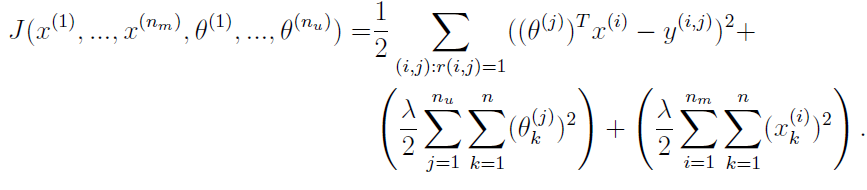

In [127]:
## ========= Part 4: Collaborative Filtering Cost Regularization ========
#  Now, you should implement regularization for the cost function for 
#  collaborative filtering. You can implement it by adding the cost of
#  regularization to the original cost computation.
#  

#  Evaluate cost function
J = cofiCostFunc(np.append(X.ravel(), Theta.ravel(), axis = None), Y, R, num_users, num_movies, \
               num_features, 1.5);
           
print('Cost at loaded parameters (lambda = 1.5): %f '\
         '\n(this value should be about 31.34)\n'%J);


Cost at loaded parameters (lambda = 1.5): 31.344056 
(this value should be about 31.34)



# 5. 协同过滤的梯度正则化

In [140]:
## ======= Part 5: Collaborative Filtering Gradient Regularization ======
#  Once your cost matches up with ours, you should proceed to implement 
#  regularization for the gradient. 
#

#  
print('\nChecking Gradients (with regularization) ... \n');

#  Check gradients by running checkNNGradients
checkCostFunction(1.5)


Checking Gradients (with regularization) ... 

[ -0.48284654  -1.89277072   2.3845097    4.0314904   -0.39889943
  -9.68138294  16.19831393  -3.65364277 -12.07427447  -1.18614184
   1.31896387  -7.65583456  -0.69664065   2.76232428  -1.03921455
  10.43013612  -3.89955239  -8.17465701  -1.15625784   1.81736417
  -5.3916996   -4.87308435  -1.56617843   6.51998819  -0.05042739
   1.7544019   -2.3537064 ]
[ -0.48284654  -1.89277072   2.3845097    4.0314904   -0.39889943
  -9.68138294  16.19831393  -3.65364277 -12.07427447  -1.18614184
   1.31896387  -7.65583456  -0.69664065   2.76232428  -1.03921455
  10.43013612  -3.89955239  -8.17465701  -1.15625784   1.81736417
  -5.3916996   -4.87308435  -1.56617843   6.51998819  -0.05042739
   1.7544019   -2.3537064 ]
['The above two columns you get should be very similar.\n(Left-Your Numerical Gradient, Right-Analytical Gradient)\n\n']
If your cost function implementation is correct, then 
the relative difference will be small (less than 1e-9). 

Re

# 6. 为新用户输入电影评分

In [155]:
def loadMovieList():
    #GETMOVIELIST reads the fixed movie list in movie.txt and returns a
    #cell array of the words
    #   movieList = GETMOVIELIST() reads the fixed movie list in movie.txt 
    #   and returns a cell array of the words in movieList.
    

    # Store all movies in cell array movie{}
    n = 1682;  # Total number of movies 

 
    movieList = []
    
    ## Read the fixed movieulary list
    with open('movie_ids.txt',encoding='gb18030',errors='ignore') as fobj:
        
        for line in fobj.readlines():
            # Word Index (can ignore since it will be = i+1)
            idx, movieName = re.split(' ',line,1)
            movieList.append(movieName.strip())
            
    return movieList


In [156]:
import re
## ============== Part 6: Entering ratings for a new user ===============
#  Before we will train the collaborative filtering model, we will first
#  add ratings that correspond to a new user that we just observed. This
#  part of the code will also allow you to put in your own ratings for the
#  movies in our dataset!
#
movieList = loadMovieList();

#  Initialize my ratings
my_ratings = np.zeros((1682, 1));

# Check the file movie_idx.txt for id of each movie in our dataset
# For example, Toy Story (1995) has ID 1, so to rate it "4", you can set
my_ratings[0] = 4;

# Or suppose did not enjoy Silence of the Lambs (1991), you can set
my_ratings[97] = 2;

# We have selected a few movies we liked / did not like and the ratings we
# gave are as follows:
my_ratings[6] = 3;
my_ratings[11]= 5;
my_ratings[53] = 4;
my_ratings[63]= 5;
my_ratings[65]= 3;
my_ratings[68] = 5;
my_ratings[182] = 4;
my_ratings[225] = 5;
my_ratings[354]= 5;

print('\n\nNew user ratings:\n');
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d for %s\n'%(my_ratings[i], movieList[i]))



New user ratings:

Rated 4 for Toy Story (1995)

Rated 3 for Twelve Monkeys (1995)

Rated 5 for Usual Suspects, The (1995)

Rated 4 for Outbreak (1995)

Rated 5 for Shawshank Redemption, The (1994)

Rated 3 for While You Were Sleeping (1995)

Rated 5 for Forrest Gump (1994)

Rated 2 for Silence of the Lambs, The (1991)

Rated 4 for Alien (1979)

Rated 5 for Die Hard 2 (1990)

Rated 5 for Sphere (1998)



# 7. 学习电影评分

In [164]:
def normalizeRatings(Y, R):
    #NORMALIZERATINGS Preprocess data by subtracting mean rating for every 
    #movie (every row)
    #   [Ynorm, Ymean] = NORMALIZERATINGS(Y, R) normalized Y so that each movie
    #   has a rating of 0 on average, and returns the mean rating in Ymean.
    #

    m, n = Y.shape
    Ymean = np.zeros((m, 1))
    Ynorm = np.zeros(Y.shape)
    for i in range(m):
        idx = np.where(R[i, :]==1)
        Ymean[i] = np.mean(Y[i, idx]);
        Ynorm[i, idx] = Y[i, idx] - Ymean[i]
    return Ynorm, Ymean


In [170]:
## ================== Part 7: Learning Movie Ratings ====================
#  Now, you will train the collaborative filtering model on a movie rating 
#  dataset of 1682 movies and 943 users
#

print('\nTraining collaborative filtering...\n');

#  Load data
#load('ex8_movies.mat');
Y = movies['Y']
R = movies['R']

#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by 
#  943 users
#
#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a
#  rating to movie i

#  Add our own ratings to the data matrix

Y = np.column_stack((my_ratings, Y))
R = np.column_stack(((my_ratings!=0).astype(int), R))

#  Normalize Ratings
Ynorm, Ymean = normalizeRatings(Y, R);

#  Useful Values
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10;

# Set Initial Parameters (Theta, X)
X = np.random.randn(num_movies, num_features);
Theta = np.random.randn(num_users, num_features);

initial_parameters = np.append(X.ravel(),Theta.ravel(),axis=None)

# Set options for fmincg
#options = optimset('GradObj', 'on', 'MaxIter', 100);

# Set Regularizatio
plambda = 10;
theta = optimize.fmin_cg (cofiCostFunc, initial_parameters, fprime = cofiGradient, args = (Ynorm, R, num_users, num_movies, \
                                num_features, plambda), \
                maxiter = 400 );

# Unfold the returned theta back into U and W
X = np.reshape(theta[:num_movies*num_features], (num_movies, num_features))
Theta = np.reshape(theta[num_movies*num_features:], \
                (num_users, num_features))

print('Recommender system learning completed.\n');


Training collaborative filtering...

         Current function value: 38951.847560
         Iterations: 400
         Function evaluations: 601
         Gradient evaluations: 601
Recommender system learning completed.



# 8. 为你推荐电影

In [234]:
my_predictions = p[:,0].reshape(-1,1) + Ymean

In [239]:
my_predictions[1652]

array([ 5.])

In [233]:
ix

array([[1535],
       [1652],
       [1121],
       [ 813],
       [1200],
       [1466],
       [1499],
       [1188],
       [1598],
       [1292],
       [1448],
       [  49],
       [  63],
       [ 118],
       [1397],
       [ 168],
       [1641],
       [1593],
       [ 317],
       [ 173],
       [ 171],
       [ 482],
       [ 407],
       [ 113],
       [  11],
       [ 312],
       [ 180],
       [ 962],
       [ 512],
       [ 133],
       [1190],
       [1638],
       [  21],
       [ 315],
       [ 602],
       [ 284],
       [ 126],
       [ 177],
       [ 271],
       [ 250],
       [  95],
       [ 356],
       [ 479],
       [ 640],
       [1063],
       [ 186],
       [ 965],
       [ 426],
       [ 510],
       [1124],
       [1523],
       [ 198],
       [ 478],
       [ 314],
       [1395],
       [ 497],
       [  88],
       [  97],
       [ 165],
       [  78],
       [1366],
       [ 483],
       [ 209],
       [ 222],
       [  47],
       [ 194],
       [ 3

In [232]:
Ymean

array([[ 3.8785872 ],
       [ 3.20610687],
       [ 3.03333333],
       [ 3.55023923],
       [ 3.30232558],
       [ 3.57692308],
       [ 3.79643766],
       [ 3.99543379],
       [ 3.89632107],
       [ 3.83146067],
       [ 3.84745763],
       [ 4.3880597 ],
       [ 3.41847826],
       [ 3.96721311],
       [ 3.778157  ],
       [ 3.20512821],
       [ 3.11956522],
       [ 2.8       ],
       [ 3.95652174],
       [ 3.41666667],
       [ 2.76190476],
       [ 4.15151515],
       [ 4.12087912],
       [ 3.44827586],
       [ 3.44368601],
       [ 3.45205479],
       [ 3.10526316],
       [ 3.93115942],
       [ 2.66666667],
       [ 3.94594595],
       [ 3.62987013],
       [ 3.79012346],
       [ 3.45360825],
       [ 2.71428571],
       [ 2.18181818],
       [ 2.15384615],
       [ 2.25      ],
       [ 3.00833333],
       [ 3.26436782],
       [ 2.89473684],
       [ 3.08108108],
       [ 3.80405405],
       [ 3.        ],
       [ 3.34177215],
       [ 4.05      ],
       [ 3

In [226]:
## ================== Part 8: Recommendation for you ====================
#  After training the model, you can now make recommendations by computing
#  the predictions matrix.
#

p = X @ Theta.T
my_predictions = p[:,0].reshape(-1,1) + Ymean;

movieList = loadMovieList();

#r = sort(my_predictions, order = 'descend');
#r = np.sort(my_predictions)[::-1] # sort desending
ix = np.argsort(my_predictions,axis=0)[::-1]
print('\nTop recommendations for you:\n');
for i in range(10):
    j = ix[i][0] #get the value instead of array
    print("j: %d"%j)
    print('Predicting rating %.1f for movie %s\n'%(my_predictions[j],movieList[j]))
    #print('Predicting rating %.1f for movie \n'%(my_predictions[j]))


print('\n\nOriginal ratings provided:\n');
for i in range(len(my_ratings)):
    if my_ratings[i] > 0 :
        print('Rated %d for %s\n'%(my_ratings[i], movieList[i]))


Top recommendations for you:

Predicting rating 5.0 for movie Aiqing wansui (1994)

Predicting rating 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996)

Predicting rating 5.0 for movie They Made Me a Criminal (1939)

Predicting rating 5.0 for movie Great Day in Harlem, A (1994)

Predicting rating 5.0 for movie Marlene Dietrich: Shadow and Light (1996)

Predicting rating 5.0 for movie Saint of Fort Washington, The (1993)

Predicting rating 5.0 for movie Santa with Muscles (1996)

Predicting rating 5.0 for movie Prefontaine (1997)

Predicting rating 5.0 for movie Someone Else's America (1995)

Predicting rating 5.0 for movie Star Kid (1997)



Original ratings provided:

Rated 4 for Toy Story (1995)

Rated 3 for Twelve Monkeys (1995)

Rated 5 for Usual Suspects, The (1995)

Rated 4 for Outbreak (1995)

Rated 5 for Shawshank Redemption, The (1994)

Rated 3 for While You Were Sleeping (1995)

Rated 5 for Forrest Gump (1994)

Rated 2 for Silence of the Lambs, The (1991)

Rate

In [213]:
ix[0].ravel()

array([1535], dtype=int64)

In [207]:
my_predictions

array([[ 3.98050733],
       [ 3.33211378],
       [ 3.27867966],
       [ 3.58947539],
       [ 3.39319329],
       [ 3.6254129 ],
       [ 3.77116676],
       [ 3.94117257],
       [ 3.75171372],
       [ 3.78701054],
       [ 3.8311368 ],
       [ 4.40760183],
       [ 3.34553223],
       [ 3.84147616],
       [ 3.9355811 ],
       [ 3.20451817],
       [ 3.22667258],
       [ 2.76384734],
       [ 3.9347206 ],
       [ 3.38713574],
       [ 2.84925281],
       [ 4.33051297],
       [ 4.0580967 ],
       [ 3.40118581],
       [ 3.34510647],
       [ 3.43270715],
       [ 3.23346437],
       [ 4.10520046],
       [ 2.93749069],
       [ 3.97244652],
       [ 3.81333726],
       [ 3.84444243],
       [ 3.66442232],
       [ 2.75254744],
       [ 2.1534705 ],
       [ 2.18015055],
       [ 2.185462  ],
       [ 3.22637157],
       [ 3.40779913],
       [ 2.92136449],
       [ 3.19106749],
       [ 3.9494064 ],
       [ 3.10006547],
       [ 3.39242896],
       [ 4.01839001],
       [ 3

In [222]:
theta

array([ -3.81327702e-01,  -2.79738269e-01,  -1.57498868e-01,
        -3.55430443e-01,   1.93914638e-01,  -2.79966640e-01,
         6.71357035e-01,  -1.04638741e+00,  -6.55990097e-01,
        -1.18345002e-01,   3.67346807e-02,  -3.11363865e-01,
         2.21838048e-01,  -1.07234123e-01,  -3.13536308e-01,
        -2.79286352e-03,   3.18991876e-01,  -5.51987050e-01,
        -3.60440563e-01,  -1.42671967e-01,   3.25677055e-01,
        -6.21495859e-01,  -3.20354835e-01,  -5.28701467e-01,
        -2.64340294e-01,  -1.46127979e-01,   2.54559780e-01,
         3.21043394e-01,   2.31317799e-01,  -2.75653605e-01,
         3.19360701e-01,   1.49097027e-01,  -4.64221461e-01,
        -2.39738364e-01,  -1.69929744e-01,   2.88888056e-02,
        -5.63358144e-02,  -7.56259167e-02,  -3.52539333e-01,
        -4.57327594e-01,   1.71963213e-01,  -2.49155957e-01,
         4.27521200e-01,   1.73695751e-01,  -3.50306565e-01,
        -7.08574866e-02,   2.33332084e-01,   1.08697139e-01,
        -1.67173295e-01,

In [223]:
theta[16820:]

array([  2.89335193e-02,  -2.35632384e-01,  -5.99773274e-02,
        -2.84881255e-02,  -1.26840779e-01,  -8.26590116e-02,
        -2.78744959e-02,  -1.05134382e-01,   1.11258662e-01,
        -8.96322232e-02,   2.03017747e-01,  -5.75953063e-02,
        -1.05170739e+00,  -1.03704730e-01,   1.65147286e-01,
         2.07256569e-01,  -3.15256267e-01,  -1.65405520e-01,
        -5.21247642e-01,   3.34141505e-01,  -9.18997470e-02,
         9.16988391e-02,  -1.06017507e-01,   1.35122856e-01,
        -9.48617100e-02,   1.19090649e-01,  -1.37476917e-01,
         1.44877929e-01,  -3.14034020e-01,  -3.03016052e-01,
        -3.10500864e-01,   4.00093657e-01,  -9.63879371e-02,
        -1.98303146e-01,  -1.51116309e-01,   4.80407216e-02,
        -5.39464931e-01,  -2.42111678e-01,   2.61466824e-01,
         1.44517529e-01,   3.22398344e-01,  -3.68402688e-01,
         2.29989221e-02,  -3.86086514e-01,   5.06552550e-02,
        -2.01053441e-01,   2.88022636e-01,  -2.26003885e-02,
        -4.30259028e-01,

In [225]:
X

array([[ -3.81327702e-01,  -2.79738269e-01,  -1.57498868e-01,
         -3.55430443e-01,   1.93914638e-01,  -2.79966640e-01,
          6.71357035e-01,  -1.04638741e+00,  -6.55990097e-01,
         -1.18345002e-01],
       [  3.67346807e-02,  -3.11363865e-01,   2.21838048e-01,
         -1.07234123e-01,  -3.13536308e-01,  -2.79286352e-03,
          3.18991876e-01,  -5.51987050e-01,  -3.60440563e-01,
         -1.42671967e-01],
       [  3.25677055e-01,  -6.21495859e-01,  -3.20354835e-01,
         -5.28701467e-01,  -2.64340294e-01,  -1.46127979e-01,
          2.54559780e-01,   3.21043394e-01,   2.31317799e-01,
         -2.75653605e-01],
       [  3.19360701e-01,   1.49097027e-01,  -4.64221461e-01,
         -2.39738364e-01,  -1.69929744e-01,   2.88888056e-02,
         -5.63358144e-02,  -7.56259167e-02,  -3.52539333e-01,
         -4.57327594e-01],
       [  1.71963213e-01,  -2.49155957e-01,   4.27521200e-01,
          1.73695751e-01,  -3.50306565e-01,  -7.08574866e-02,
          2.33332084e-01

In [224]:
Theta

array([[  2.89335193e-02,  -2.35632384e-01,  -5.99773274e-02,
         -2.84881255e-02,  -1.26840779e-01,  -8.26590116e-02,
         -2.78744959e-02,  -1.05134382e-01,   1.11258662e-01,
         -8.96322232e-02],
       [  2.03017747e-01,  -5.75953063e-02,  -1.05170739e+00,
         -1.03704730e-01,   1.65147286e-01,   2.07256569e-01,
         -3.15256267e-01,  -1.65405520e-01,  -5.21247642e-01,
          3.34141505e-01],
       [ -9.18997470e-02,   9.16988391e-02,  -1.06017507e-01,
          1.35122856e-01,  -9.48617100e-02,   1.19090649e-01,
         -1.37476917e-01,   1.44877929e-01,  -3.14034020e-01,
         -3.03016052e-01],
       [ -3.10500864e-01,   4.00093657e-01,  -9.63879371e-02,
         -1.98303146e-01,  -1.51116309e-01,   4.80407216e-02,
         -5.39464931e-01,  -2.42111678e-01,   2.61466824e-01,
          1.44517529e-01],
       [  3.22398344e-01,  -3.68402688e-01,   2.29989221e-02,
         -3.86086514e-01,   5.06552550e-02,  -2.01053441e-01,
          2.88022636e-01

In [221]:
Theta.shape

(944, 10)